## Load Python Packages


In [ ]:
# --- load packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn.modules.distance import PairwiseDistance
from torch.utils.data import Dataset
from torchvision import transforms
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from torch.nn import functional as F


import time
from collections import OrderedDict
import numpy as np
import os
from skimage import io
from PIL import Image
import cv2
import matplotlib.pyplot as plt


## Set parameters

In [ ]:
# --- Set all Parameters
DatasetFolder = "./CASIA-WebFace"  # path to Dataset folder
ResNet_sel = "18"                  # select ResNet type
NumberID = 10575                   # Number of ID in dataset 
batch_size = 256                   # size of batch size
Triplet_size = 10000 * batch_size  # size of total Triplets
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_margin = 0.6                  # Margin for Triplet loss
learning_rate = 0.075              # choose Learning Rate(note that this value will be change during training)
epochs = 200                       # number of iteration over total dataset


## Download Datasets
#### In this section we download CASIA-WebFace and LFW-Dataset
#### we use CAISA-WebFace for Training and LFW for Evaluation

In [ ]:
# --- Download CASIA-WebFace Dataset
print(40*"=" + " Download CASIA WebFace " + 40*'=')
! gdown --id 1Of_EVz-yHV7QVWQGihYfvtny9Ne8qXVz
! unzip CASIA-WebFace.zip
! rm CASIA-WebFace.zip

# --- Download LFW Dataset
print(40*"=" + " Download LFW " + 40*'=')
! wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
! tar -xvzf lfw-deepfunneled.tgz
! rm lfw-deepfunneled.tgz

# Define ResNet Parts
#### 1. Residual block
#### 2. Make ResNet by Prv. block

In [ ]:
# --- Residual block
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, downsample=1):
    super().__init__()
    # --- Variables
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.downsample = downsample

    # --- Residual parts
    # --- Conv part
    self.blocks = nn.Sequential(OrderedDict(
        {
            # --- First Conv
            'conv1' : nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=self.downsample, padding=1, bias=False),
            'bn1'   : nn.BatchNorm2d(self.out_channels),
            'Relu1' : nn.ReLU(),
         
            # --- Secound Conv
            'conv2' : nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            'bn2'   : nn.BatchNorm2d(self.out_channels)
        }
    ))
    # --- shortcut part
    self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=self.downsample, bias=False),
            'bn'   : nn.BatchNorm2d(self.out_channels)
        }
    ))
  
  def forward(self, x):
    residual = x
    if (self.in_channels != self.out_channels) : residual = self.shortcut(x)
    x = self.blocks(x)
    x += residual
    return x





In [ ]:
# # --- Test Residual block
# dummy = torch.ones((1, 32, 140, 140))

# block = ResidualBlock(32, 64)
# block(dummy).shape
# print(block)


In [ ]:
# --- Make ResNet18
class ResNet18(nn.Module):
  def __init__(self):
    super().__init__()

    # --- Pre layers with 7*7 conv with stride2 and a max-pooling
    self.PreBlocks = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

    # --- Define all Residual Blocks here
    self.CoreBlocka = nn.Sequential(
        ResidualBlock(64,64 ,downsample=1),
        ResidualBlock(64,64 ,downsample=1),
        # ResidualBlock(64,64 ,downsample=1),

        ResidualBlock(64,128 ,downsample=2),
        ResidualBlock(128,128 ,downsample=1),
        # ResidualBlock(128,128 ,downsample=1),
        # ResidualBlock(128,128 ,downsample=1),

        ResidualBlock(128,256 ,downsample=2),
        ResidualBlock(256,256 ,downsample=1),
        # ResidualBlock(256,256 ,downsample=1),
        # ResidualBlock(256,256 ,downsample=1),
        # ResidualBlock(256,256 ,downsample=1),
        # ResidualBlock(256,256 ,downsample=1),

        ResidualBlock(256,512 ,downsample=2),
        ResidualBlock(512,512 ,downsample=1),
        # ResidualBlock(512,512 ,downsample=1)
    )

    # --- Make Average pooling
    self.avg = nn.AdaptiveAvgPool2d((1,1))

    # --- FC layer for output
    self.fc = nn.Linear(512, 512, bias=False)

  def forward(self, x):
    x = self.PreBlocks(x)
    x = self.CoreBlocka(x)
    x = self.avg(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    x = F.normalize(x, p=2, dim=1)
    return x

In [ ]:
# dummy = torch.ones((1, 3, 114, 144))
model = ResNet18()
# model
# res = model(dummy)

model.to(device)
summary(model, (3, 114, 114))
del model

# Make TripletLoss Class 

In [ ]:
# --- Triplet loss
"""
    This code was imported from tbmoon's 'facenet' repository:
    https://github.com/tbmoon/facenet/blob/master/utils.py
    
"""

import torch
from torch.autograd import Function
from torch.nn.modules.distance import PairwiseDistance


class TripletLoss(Function):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(p=2)

    def forward(self, anchor, positive, negative):
        pos_dist = self.pdist.forward(anchor, positive)
        neg_dist = self.pdist.forward(anchor, negative)
        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min=0.0)
        loss = torch.mean(hinge_dist)
        # print(torch.mean(pos_dist).item(), torch.mean(neg_dist).item(), loss.item())
        # print("pos_dist", pos_dist)
        # print("neg_dist", neg_dist)
        # print(self.margin + pos_dist - neg_dist)
        return loss


# Make Triplet Dataset from CASIA-WebFace

##### 1. Make Triplet pairs
##### 2. Make them zip
##### 3. Make Dataset Calss
##### 4. Define Transform

In [ ]:
# --- Create Triplet Datasets ---
# --- make a list of ids and folders
selected_ids = np.uint32(np.round((np.random.rand(int(Triplet_size))) * (NumberID-1)))
folders = os.listdir("./CASIA-WebFace/")

# --- Itrate on each id and make Triplets list
TripletList = []

for index,id in enumerate(selected_ids):

  # --- find name of id faces folder
  id_str = str(folders[id])

  # --- find list of faces in this folder
  number_faces = os.listdir("./CASIA-WebFace/"+id_str)

  # --- Get two Random number for Anchor and Positive
  while(True):
    two_random = np.uint32(np.round(np.random.rand(2) * (len(number_faces)-1))) 
    if (two_random[0] != two_random[1]):
      break

  # --- Make Anchor and Positive image
  Anchor   = str(number_faces[two_random[0]])
  Positive = str(number_faces[two_random[1]])

  # --- Make Negative image
  while(True):
    neg_id = np.uint32(np.round(np.random.rand(1) * (NumberID-1)))
    if (neg_id != id):
      break
  # --- number of images in negative Folder
  neg_id_str   = str(folders[neg_id[0]])
  number_faces = os.listdir("./CASIA-WebFace/"+neg_id_str)
  one_random   = np.uint32(np.round(np.random.rand(1) * (len(number_faces)-1))) 
  Negative     = str(number_faces[one_random[0]])
  
  # --- insert Anchor, Positive and Negative image path to TripletList
  TempList = ["","",""]
  TempList[0] =  id_str + "/" + Anchor
  TempList[1] =  id_str + "/" + Positive
  TempList[2] =  neg_id_str + "/" + Negative
  TripletList.append(TempList)

  







In [ ]:
# # --- Make dataset Triplets File
# f = open("CASIA-WebFace-Triplets.txt", "w")
# for index, triplet in enumerate(TripletList):
#   f.write(triplet[0] + " " + triplet[1] + " " + triplet[2])
#   if (index != len(TripletList)-1):
#     f.write("\n")
# f.close()


# # --- Make zipFile if you need
# !zip -r CASIA-WebFace-Triplets.zip CASIA-WebFace-Triplets.txt

In [ ]:
# # --- Read zip File and extract TripletList
# TripletList = []
# # !unzip CASIA-WebFace-Triplets.zip

# # --- Read text file
# with open('CASIA-WebFace-Triplets.txt') as f:
#     lines = f.readlines()
#     for line in lines:
#       TripletList.append(line.split(' '))
#       TripletList[-1][2] = TripletList[-1][2][0:-1]

# # --- Print some data
# print(TripletList[0:5])


In [ ]:
# --- Make Pytorch Dataset Class for Triplets 
class TripletFaceDatset(Dataset):
  def __init__(self, list_of_triplets, transform=None):
    # --- initializing values
    print("Start Creating Triplets Dataset from CASIA-WebFace")
    self.list_of_triplets = list_of_triplets
    self.transform = transform

  # --- getitem function
  def __getitem__(self, index):
    # --- get images path and read faces
    anc_img_path, pos_img_path, neg_img_path = self.list_of_triplets[index]
    anc_img = cv2.imread('./CASIA-WebFace/'+anc_img_path)
    pos_img = cv2.imread('./CASIA-WebFace/'+pos_img_path)
    neg_img = cv2.imread('./CASIA-WebFace/'+neg_img_path)

    # anc_img = cv2.resize(anc_img, (114,114))
    # pos_img = cv2.resize(pos_img, (114,114))
    # neg_img = cv2.resize(neg_img, (114,114))


    # --- set transform
    if self.transform:
      anc_img = self.transform(anc_img)
      pos_img = self.transform(pos_img)
      neg_img = self.transform(neg_img)
    
    return {'anc_img' : anc_img,
            'pos_img' : pos_img,
            'neg_img' : neg_img}
  
  # --- return len of triplets
  def __len__(self):
    return len(self.list_of_triplets)
  





In [ ]:
# --- Define Transforms
transform_list =transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize((140,140)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std =[0.229, 0.224, 0.225])
                 ])



In [ ]:
# --- Test Dataset
triplet_dataset = TripletFaceDatset(TripletList, transform_list)
triplet_dataset[0]['anc_img'].shape

Start Creating Triplets Dataset from CASIA-WebFace


torch.Size([3, 140, 140])

# LFW Evaluation
##### 1. Face detection function
##### 2. Load LFW Pairs .npy file
##### 3. Define Function for evaluation 

In [ ]:
# -------------------------- UTILS CELL -------------------------------

trained_face_data = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
# --- define Functions
def face_detect(file_name):
  flag = True
  # Choose an image to detect faces in
  img = cv2.imread(file_name)

  # Must convert to greyscale
  # grayscaled_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Detect Faces 
  # face_coordinates = trained_face_data.detectMultiScale(grayscaled_img)

  # img_crop = []
  # Draw rectangles around the faces
  # for (x, y, w, h) in face_coordinates:
  #   img_crop.append(img[y-20:y+h+20, x-20:x+w+20])

  # --- select only Biggest
  # big_id = 0
  # if len(img_crop) > 1:
  #   temp = 0
  #   for idx, img in enumerate(img_crop):
  #     if img.shape[0] > temp:
  #       temp = img.shape[0]
  #       big_id = idx
  # elif len(img_crop) == 0:
  #   flag = False
  #   img_crop = [0]

  # return image crop
  # return [img_crop[big_id]], flag
  return [img], flag

In [ ]:
# --- LFW Dataset loading for test part
l2_dist = PairwiseDistance(2)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
# --- 1. Load .npy pairs path
lfw_pairs_path = np.load('lfw_pairs_path.npy', allow_pickle=True)
pairs_dist_list_mat = []
pairs_dist_list_unmat = []
valid_thresh = 0.96

def lfw_validation(model):
  global valid_thresh
  tot_len = len(lfw_pairs_path)

  model.eval() # use model in evaluation mode
  with torch.no_grad():
    true_match = 0
    for path in lfw_pairs_path:
      # --- extracting
      pair_one_path = path['pair_one']
      # print(pair_one_path)
      pair_two_path = path['pair_two']
      # print(pair_two_path)
      matched       = int(path['matched'])

      # --- detect face and resize it
      pair_one_img, flag_one = face_detect(pair_one_path)
      pair_two_img, flag_two = face_detect(pair_two_path)

      if (flag_one==False) or (flag_two==False):
        tot_len = tot_len-1
        continue
      

      # --- Model Predict
      pair_one_img = transform_list(pair_one_img[0])
      pair_two_img = transform_list(pair_two_img[0])
      pair_one_embed = model(torch.unsqueeze(pair_one_img, 0).to(device))
      pair_two_embed = model(torch.unsqueeze(pair_two_img, 0).to(device))
      
      # print(pair_one_embed.shape)
      # break
      # print(pair_one_img)
      # break
      # --- find Distance
      pairs_dist = l2_dist.forward(pair_one_embed, pair_two_embed)
      if matched == 1: pairs_dist_list_mat.append(pairs_dist.item())
      if matched == 0: pairs_dist_list_unmat.append(pairs_dist.item())
      

      # --- thrsholding
      if (matched==1 and pairs_dist.item() <= valid_thresh) or (matched==0 and pairs_dist.item() > valid_thresh):
        true_match += 1

  valid_thresh = (np.percentile(pairs_dist_list_unmat,25) + np.percentile(pairs_dist_list_mat,75)) /2
  print("Thresh :", valid_thresh)
  return (true_match/tot_len)*100



In [ ]:
# img, _ = face_detect("./lfw-deepfunneled/Steve_Lavin/Steve_Lavin_0002.jpg")
# plt.imshow(img[0])
# plt.show()

In [ ]:
temp = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in temp:
  valid_thresh = i
  print(lfw_validation(model))

TypeError: ignored

In [ ]:
(np.mean(pairs_dist_list_mat) + np.mean(pairs_dist_list_unmat) )/2

In [ ]:
ppairs_dist_list_unmat

In [ ]:
# --- find best thresh
round_unmat = pairs_dist_list_unmat
round_mat = pairs_dist_list_mat

print("----- Unmatched statistical information -----")
print("len  : ",len(round_unmat))
print("min  : ", np.min(round_unmat))
print("Q1   : ", np.percentile(round_unmat, 15))
print("mean : ", np.mean(round_unmat))
print("Q3   : ", np.percentile(round_unmat, 75))
print("max  : ", np.max(round_unmat))

print("\n")
print("----- matched statistical information -----")
print("len  : ",len(round_mat))
print("min  : ", np.min(round_mat))
print("Q1   : ", np.percentile(round_mat, 25))
print("mean : ", np.mean(round_mat))
print("Q3   : ", np.percentile(round_mat, 85))
print("max  : ", np.max(round_mat))

## How to make Training Faster

In [ ]:
# Make Trianing Faster in Pytorch(Cuda):
# 1. use number of worker
# 2. set pin_memory
# 3. Enable cuDNN for optimizing Conv
# 4. using AMP
# 5. set bias=False in conv layer if you set batch normalizing in model



# source: https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b

# DataLoader

In [ ]:
# --- DataLoader
face_data = torch.utils.data.DataLoader(triplet_dataset, 
                                       batch_size= batch_size,
                                       shuffle=True,
                                       num_workers=4,
                                       pin_memory= True)

# --- Enable cuDNN
torch.backends.cudnn.benchmark = True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Save Model (best acc. and last acc.)

In [ ]:
# --- saving model for best and last model

# --- Connect to google Drive for saving models
from google.colab import drive
drive.mount('/content/gdrive')

# --- some variable for saving models
BEST_MODEL_PATH = "./gdrive/MyDrive/best_trained.pth"
LAST_MODEL_PATH = "./gdrive/MyDrive/last_trained.pth"


def save_model(model_sv, loss_sv, epoch_sv, optimizer_state_sv, accuracy, accu_sv_list, loss_sv_list):
  # --- Inputs:
  #     1. model_sv           : orginal model that trained
  #     2. loss_sv            : current loss
  #     3. epoch_sv           : current epoch
  #     4. optimizer_state_sv : current value of optimizer 
  #     5. accuracy           : current accuracy
  
  # --- save last epoch
  if accuracy >= max(accu_sv_list): 
    torch.save(model.state_dict(), BEST_MODEL_PATH)
  
  # --- save this model for checkpoint
  torch.save({
            'epoch': epoch_sv,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_state_sv.state_dict(),
            'loss': loss_sv,
            'accu_sv_list': accu_sv_list,
            'loss_sv_list' : loss_sv_list
             }, LAST_MODEL_PATH)


Mounted at /content/gdrive


# Load prev. model for continue training

In [ ]:
torch.cuda.empty_cache()

# --- training initialize and start
model       = ResNet18().to(device)                                                 # load model                                                       
tiplet_loss = TripletLoss(loss_margin)                                              # load Tripletloss
optimizer   = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                         lr=learning_rate)                                          # load optimizer
l2_dist     = PairwiseDistance(2)                                                   # L2 distance loading                                                                    # save loss values
epoch_check = 0
valid_arr   = []
loss_arr    = []


load_last_epoch = True
if (load_last_epoch == True):
  # --- load last model
  # define model objects before this
  checkpoint = torch.load(LAST_MODEL_PATH, map_location=device)                      # load model path
  model.load_state_dict(checkpoint['model_state_dict'])         # load state dict
  optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # load optimizer
  epoch_check = checkpoint['epoch']                             # load epoch
  loss = checkpoint['loss']                                     # load loss value
  valid_arr = checkpoint['accu_sv_list']                        # load Acc. values
  loss_arr = checkpoint['loss_sv_list']                         # load loss values
model.train()  


In [ ]:
epoch_check

107

In [ ]:
loss

0.004417351509642321

# Training Loop

In [ ]:
model.train()
# --- Training loop based on number of epoch
temp = 0.075
for epoch in range(epoch_check,200):
  print(80*'=')
  
  # --- For saving imformation
  triplet_loss_sum = 0.0
  len_face_data = len(face_data)

  # -- set starting time
  time0 = time.time()

  # --- make learning rate update
  if 50 < len(loss_arr):
    for g in optimizer.param_groups:
      g['lr'] = 0.001
      temp = 0.001

  # --- loop on batches
  for batch_idx, batch_faces in enumerate(face_data):
    # --- Extract face triplets and send them to CPU or GPU
    anc_img = batch_faces['anc_img'].to(device)
    pos_img = batch_faces['pos_img'].to(device)
    neg_img = batch_faces['neg_img'].to(device)

    # --- Get embedded values for each triplet
    anc_embed = model(anc_img)
    pos_embed = model(pos_img)
    neg_embed = model(neg_img)
    

    # --- Find Distance
    pos_dist = l2_dist.forward(anc_embed, pos_embed)
    neg_dist = l2_dist.forward(anc_embed, neg_embed)

    # --- Select hard triplets
    all = (neg_dist - pos_dist < 0.8).cpu().numpy().flatten()
    hard_triplets = np.where(all == 1)

    if len(hard_triplets[0]) == 0: # --- Check number of hard triplets
      continue
    
    # --- select hard embeds
    anc_hard_embed = anc_embed[hard_triplets]
    pos_hard_embed = pos_embed[hard_triplets]
    neg_hard_embed = neg_embed[hard_triplets]

    # --- Loss
    loss_value = tiplet_loss.forward(anc_hard_embed, pos_hard_embed, neg_hard_embed)

    # --- backward path
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

    if (batch_idx % 200 == 0) : print("Epoch: [{}/{}]  ,Batch index: [{}/{}], Loss Value:[{:.8f}]".format(epoch+1, epochs, batch_idx+1, len_face_data,loss_value))
    # --- save information
    triplet_loss_sum += loss_value.item()
  
  print("Learning Rate: ", temp)


  # --- Find Avg. loss value
  avg_triplet_loss = triplet_loss_sum / len_face_data
  loss_arr.append(avg_triplet_loss)

  
  # --- Validation part besed on LFW Dataset
  validation_acc = lfw_validation(model)
  valid_arr.append(validation_acc)
  model.train()

  # --- Save model with checkpoints
  save_model(model, avg_triplet_loss, epoch+1, optimizer, validation_acc, valid_arr, loss_arr)

  # --- Print information for each epoch
  print(" Train set - Triplet Loss    =  {:.8f}".format(avg_triplet_loss))
  print(' Train set - Accuracy        = {:.8f}'.format(validation_acc))
  print(f' Execution time              = {time.time() - time0}')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1/200]  ,Batch index: [1/10000], Loss Value:[0.55121058]
Epoch: [1/200]  ,Batch index: [201/10000], Loss Value:[0.56104153]
Epoch: [1/200]  ,Batch index: [401/10000], Loss Value:[0.51668715]
Epoch: [1/200]  ,Batch index: [601/10000], Loss Value:[0.46920896]
Epoch: [1/200]  ,Batch index: [801/10000], Loss Value:[0.51631397]
Epoch: [1/200]  ,Batch index: [1001/10000], Loss Value:[0.46902987]
Epoch: [1/200]  ,Batch index: [1201/10000], Loss Value:[0.46686172]
Epoch: [1/200]  ,Batch index: [1401/10000], Loss Value:[0.47691041]
Epoch: [1/200]  ,Batch index: [1601/10000], Loss Value:[0.50785959]
Epoch: [1/200]  ,Batch index: [1801/10000], Loss Value:[0.44824705]
Epoch: [1/200]  ,Batch index: [2001/10000], Loss Value:[0.35941172]
Epoch: [1/200]  ,Batch index: [2201/10000], Loss Value:[0.47547746]
Epoch: [1/200]  ,Batch index: [2401/10000], Loss Value:[0.39145350]
Epoch: [1/200]  ,Batch index: [2601/10000], Loss Value:[0.41670471]
Epoch: [1/200]  ,Batch index: [2801/10000], Loss Value:

# plot and print some information

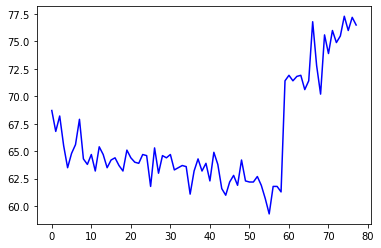

In [ ]:
plt.plotvalid_arr(, 'b-', 
         label='Validation Accuracy',
         
         )
plt.show()

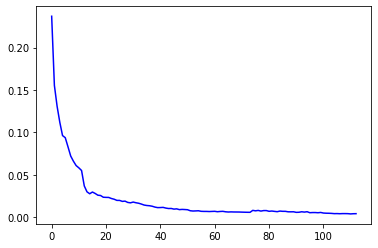

In [ ]:
plt.plot(loss_arr, 'b-', 
         label='loss values',
         
         )
plt.show()

In [ ]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.01875


In [ ]:
valid_arr

In [ ]:
print(40*"=" + " Download CASIA WebFace " + 40*'=')
! gdown --id 1Of_EVz-yHV7QVWQGihYfvtny9Ne8qXVz
! unzip CASIA-WebFace.zip
! rm CASIA-WebFace.zip

In [ ]:
# --- LFW Dataset loading for test part
l2_dist = PairwiseDistance(2)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

valid_thresh = 0.96

  

model.eval()
with torch.no_grad():
  # --- extracting
  pair_one_path = "./3.jpg"
  # print(pair_one_path)
  pair_two_path = "./2.jpg"

  # --- detect face and resize it
  pair_one_img, flag_one = face_detect(pair_one_path)
  pair_two_img, flag_two = face_detect(pair_two_path)

  # --- Model Predict
  pair_one_img = transform_list(pair_one_img[0])
  pair_two_img = transform_list(pair_two_img[0])
  pair_one_embed = model(torch.unsqueeze(pair_one_img, 0).to(device))
  pair_two_embed = model(torch.unsqueeze(pair_two_img, 0).to(device))

  # --- find Distance
  pairs_dist = l2_dist.forward(pair_one_embed, pair_two_embed)
  print(pairs_dist)
  

tensor([0.9349], device='cuda:0')


In [ ]:
# --- Create Triplet Datasets ---
# --- make a list of ids and folders
selected_ids = np.uint32(np.round((np.random.rand(int(Triplet_size))) * (NumberID-1)))
folders = os.listdir("./CASIA-WebFace/")

# --- Itrate on each id and make Triplets list
TripletList = []

for index,id in enumerate(selected_ids):
  # --- print info
  # print(40*"=" + str(index) + 40*"=")
  # print(index)

  # --- find name of id faces folder
  id_str = str(folders[id])

  # --- find list of faces in this folder
  number_faces = os.listdir("./CASIA-WebFace/"+id_str)

  # --- Get two Random number for Anchor and Positive
  while(True):
    two_random = np.uint32(np.round(np.random.rand(2) * (len(number_faces)-1))) 
    if (two_random[0] != two_random[1]):
      break

  # --- Make Anchor and Positive image
  Anchor   = str(number_faces[two_random[0]])
  Positive = str(number_faces[two_random[1]])

  # --- Make Negative image
  while(True):
    neg_id = np.uint32(np.round(np.random.rand(1) * (NumberID-1)))
    if (neg_id != id):
      break
  # --- number of images in negative Folder
  neg_id_str   = str(folders[neg_id[0]])
  number_faces = os.listdir("./CASIA-WebFace/"+neg_id_str)
  one_random   = np.uint32(np.round(np.random.rand(1) * (len(number_faces)-1))) 
  Negative     = str(number_faces[one_random[0]])
  
  # --- insert Anchor, Positive and Negative image path to TripletList
  TempList = ["","",""]
  TempList[0] =  id_str + "/" + Anchor
  TempList[1] =  id_str + "/" + Positive
  TempList[2] =  neg_id_str + "/" + Negative
  TripletList.append(TempList)
  # print(TripletList[-1])